## Prometne nesreče v Sloveniji
Projektna naloga pri predmetu Podatkovno rudarjenje


#### Import podatkov za nesreče

In [1]:
import pandas as pd
file_path = 'podatki/pn2009_2023.csv' 

def load_accident_data(file_path):

    try:
        df = pd.read_csv(file_path, sep=',')  
        return df
    except FileNotFoundError:
        print(f"Error: File not found at path: {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred while loading the data: {e}")
        return None

accident_data = load_accident_data(file_path)

### 1. Kje se dogaja največ nesreč?

#### Območja, kjer se je med leti 2009 in 2023 zgodilo največ nesreč, prikazano s pomočjo heatmap.

In [2]:
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import HeatMap
from IPython.display import display

if accident_data is not None:
    sample = accident_data.dropna(subset=["GeoKoordinataX", "GeoKoordinataY"]).sample(n=3000, random_state=42)
    sample["GeoKoordinataX"] = sample["GeoKoordinataX"].astype(str).str.replace(',', '.').astype(float)
    sample["GeoKoordinataY"] = sample["GeoKoordinataY"].astype(str).str.replace(',', '.').astype(float)

    geometry = [Point(xy) for xy in zip(sample["GeoKoordinataY"], sample["GeoKoordinataX"])]
    gdf = gpd.GeoDataFrame(sample, geometry=geometry, crs="EPSG:3794")
    gdf = gdf.to_crs(epsg=4326)
    gdf = gdf[
        (gdf.geometry.y >= 45.4) & (gdf.geometry.y <= 47.1) &
        (gdf.geometry.x >= 13.3) & (gdf.geometry.x <= 16.6)
    ]

    if len(gdf) > 0:
        heat_data = [[point.y, point.x] for point in gdf.geometry]
        m = folium.Map(location=[46.1512, 14.9955], zoom_start=8, tiles="CartoDB positron")
        HeatMap(heat_data, radius=10, blur=15, min_opacity=0.3).add_to(m)
        display(m)
    else:
        print("Po filtriranju ni ostalo nobenih podatkov v Sloveniji.")
else:
    print("Podatkovna datoteka ni bila uspešno naložena.")

#### Top 10 odsekov, kjer se zgodi največ nesreč (glede na prometno obremenitev cest)

                   OpisOdseka  SteviloNesrec     AADT  NesreceNaMilijonVozil
1288            MURSKA SOBOTA            280  10000.0              76.712329
1752                  ROGATEC             48   2500.0              52.602740
1319              NOVA GORICA            199  10500.0              51.924331
710                 GROSUPLJE             99   8800.0              30.821918
2480        ŠENTILJ - PESNICA             47   4364.0              29.506674
942                   KOČEVJE             79   7700.0              28.108877
662            GORNJA RADGONA             55   6700.0              22.490288
668   GORNJI DOLIČ - STRANICE             24   3173.0              20.722794
1544                  POLZELA             20   2700.0              20.294267
2518              ŠKOFJA LOKA            133  19959.0              18.256604


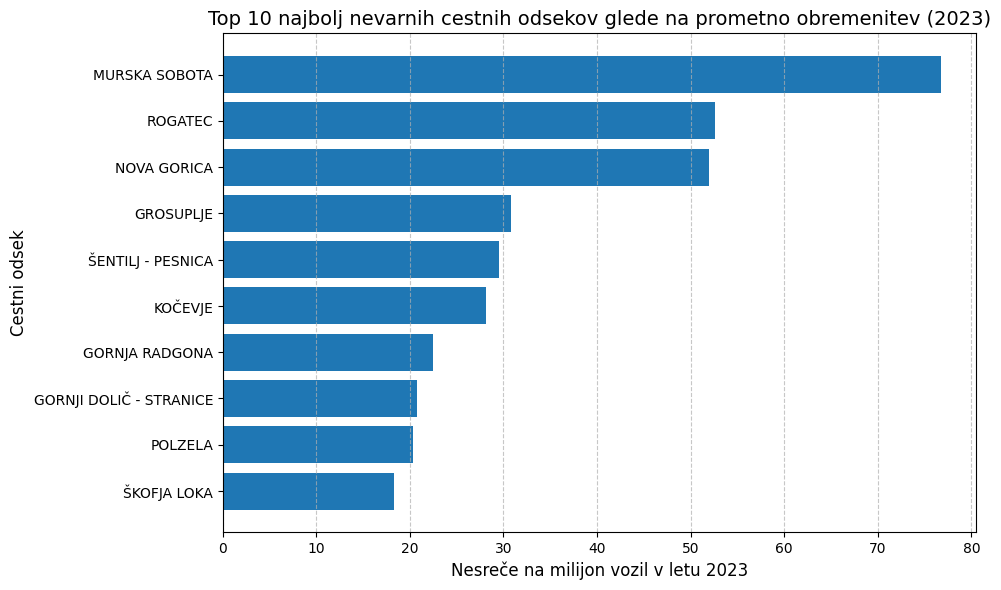

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

nesrece = accident_data
pldp = pd.read_excel('podatki/pldp2023noo.xlsx')

nesrece_2023 = nesrece[nesrece["Leto"] == 2023].copy()
nesrece_2023['OpisOdseka'] = nesrece_2023['TekstCesteNaselja'].str.strip()

pldp['Prometni odsek'] = pldp['Prometni odsek'].str.strip()
pldp['AADT'] = pd.to_numeric(pldp['Vsa vozila (PLDP)'], errors='coerce')

merged = nesrece_2023.merge(pldp, left_on='OpisOdseka', right_on='Prometni odsek', how='left')

nesrece_na_odsek = (
    merged.groupby('OpisOdseka')
    .agg({'ZaporednaStevilkaPN': 'count', 'AADT': 'first'})
    .rename(columns={'ZaporednaStevilkaPN': 'SteviloNesrec'})
    .reset_index()
)

nesrece_na_odsek['NesreceNaMilijonVozil'] = (
    nesrece_na_odsek['SteviloNesrec'] / (nesrece_na_odsek['AADT'] * 365) * 1_000_000
)
nesrece_na_odsek = nesrece_na_odsek[nesrece_na_odsek['SteviloNesrec'] >= 20]

top10 = nesrece_na_odsek.sort_values('NesreceNaMilijonVozil', ascending=False).head(10)
print(top10[['OpisOdseka', 'SteviloNesrec', 'AADT', 'NesreceNaMilijonVozil']])

plt.figure(figsize=(10, 6))
plt.barh(top10['OpisOdseka'], top10['NesreceNaMilijonVozil'])
plt.title("Top 10 najbolj nevarnih cestnih odsekov glede na prometno obremenitev (2023)", fontsize=14)
plt.xlabel("Nesreče na milijon vozil v letu 2023", fontsize=12)
plt.ylabel("Cestni odsek", fontsize=12)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

### 2. Najpogostejši vzroki za prometne nesreče


Osnovna statistika vzrokov nesreč:
Skupno število različnih vzrokov: 11
Top 5 vzrokov predstavlja 85.0% vseh nesreč

Najpogostejši vzroki za nesreče z deležem:
                                   count  Delež (%)  Kumulativni delež (%)
VzrokNesrece                                                              
PREMIKI Z VOZILOM                 123644  23.669133              23.669133
NEUPOŠTEVANJE PRAVIL O PREDNOSTI   88277  16.898839              40.567972
NEPRILAGOJENA HITROST              83660  16.015008              56.582980
NEUSTREZNA VARNOSTNA RAZDALJA      75122  14.380581              70.963561
NEPRAVILNA STRAN / SMER VOŽNJE     73313  14.034285              84.997846
OSTALO                             55869  10.694985              95.692832
NEPRAVILNO PREHITEVANJE            14229   2.723853              98.416685
NEPRAVILNOSTI PEŠCA                 3310   0.633632              99.050317
NEPRAVILNOSTI NA TOVORU             2613   0.500206              99.550523
NEPRAVILNOSTI 

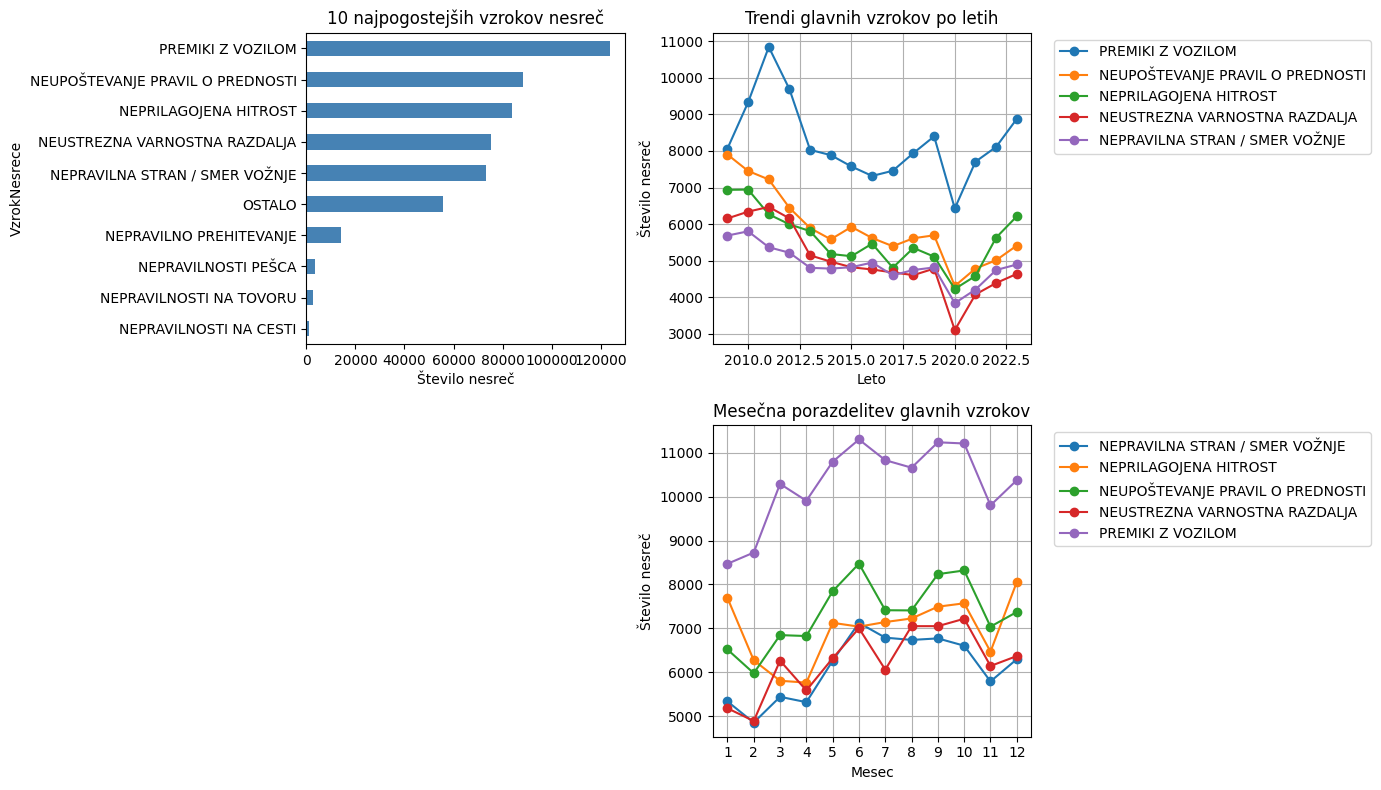


Vzroki z najvišjim deležem smrtnih žrtev:
PoskodbaUdelezenca                SMRT  Delež smrti (%)
VzrokNesrece                                           
NEPRAVILNOSTI PEŠCA                 65         1.971489
NEPRILAGOJENA HITROST              658         0.794868
NEPRAVILNA STRAN / SMER VOŽNJE     489         0.672766
NEPRAVILNO PREHITEVANJE             79         0.557910
NEUPOŠTEVANJE PRAVIL O PREDNOSTI   240         0.272854


In [4]:
import matplotlib.pyplot as plt

if accident_data is not None:
    vzroki_counts = accident_data['VzrokNesrece'].value_counts()
    
    print("\nOsnovna statistika vzrokov nesreč:")
    print(f"Skupno število različnih vzrokov: {len(vzroki_counts)}")
    print(f"Top 5 vzrokov predstavlja {vzroki_counts.head(5).sum()/len(accident_data)*100:.1f}% vseh nesreč")
    
    vzroki_po_letih = accident_data.groupby(['Leto', 'VzrokNesrece']).size().unstack().fillna(0)
    
    print("\nNajpogostejši vzroki za nesreče z deležem:")
    top_vzroki = vzroki_counts.head(10).to_frame()
    top_vzroki['Delež (%)'] = (top_vzroki['count'] / len(accident_data)) * 100
    top_vzroki['Kumulativni delež (%)'] = top_vzroki['Delež (%)'].cumsum()
    print(top_vzroki)
    
    glavni_vzroki = vzroki_counts.head(5).index.tolist()
    trendi_vzrokov = vzroki_po_letih[glavni_vzroki]
    
    plt.figure(figsize=(14, 8))
    
    # Graf 1: Najpogostejši vzroki
    plt.subplot(2, 2, 1)
    vzroki_counts.head(10).plot(kind='barh', color='steelblue')
    plt.title('10 najpogostejših vzrokov nesreč')
    plt.xlabel('Število nesreč')
    plt.gca().invert_yaxis()
    
    # Graf 2: Trendi glavnih vzrokov
    plt.subplot(2, 2, 2)
    for vzrok in glavni_vzroki:
        plt.plot(trendi_vzrokov.index, trendi_vzrokov[vzrok], label=vzrok, marker='o')
    plt.title('Trendi glavnih vzrokov po letih')
    plt.xlabel('Leto')
    plt.ylabel('Število nesreč')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    
    # Graf 4: Porazdelitev po mesecih za glavne vzroke
    plt.subplot(2, 2, 4)
    accident_data['Mesec'] = pd.to_datetime(accident_data['DatumPN'], errors='coerce').dt.month
    mesecna_porazdelitev = accident_data[accident_data['VzrokNesrece'].isin(glavni_vzroki)]
    mesecna_porazdelitev = mesecna_porazdelitev.groupby(['Mesec', 'VzrokNesrece']).size().unstack()
    mesecna_porazdelitev.plot(kind='line', marker='o', ax=plt.gca())
    plt.title('Mesečna porazdelitev glavnih vzrokov')
    plt.xlabel('Mesec')
    plt.ylabel('Število nesreč')
    plt.xticks(range(1, 13))
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()
    
    # Povezava med vzrokom in resnostjo nesreče
    resnost_vzrok = pd.crosstab(accident_data['VzrokNesrece'], 
                               accident_data['PoskodbaUdelezenca'])
    resnost_vzrok['Delež smrti (%)'] = resnost_vzrok['SMRT'] / resnost_vzrok.sum(axis=1) * 100
    print("\nVzroki z najvišjim deležem smrtnih žrtev:")
    print(resnost_vzrok.sort_values('Delež smrti (%)', ascending=False).head(5)[['SMRT', 'Delež smrti (%)']])
    
else:
    print("Napaka pri nalaganju podatkov")

### 3. Povzročitelji nesreč po starosti

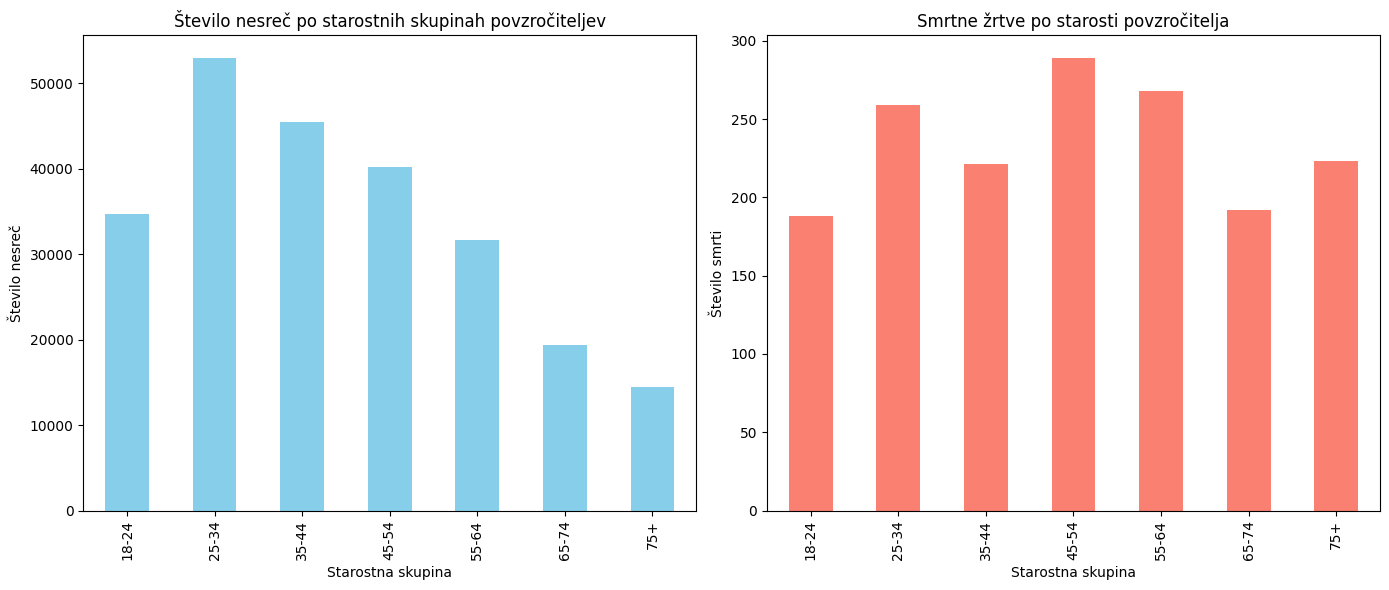


Statistika za mlade voznike (18-24 let):
Povprečna starost: 20.6 let
Delež med vsemi povzročitelji: 14.2%

5 najpogostejših vzrokov nesreč pri mladih voznikih:
VzrokNesrece
NEPRILAGOJENA HITROST               11048
NEPRAVILNA STRAN / SMER VOŽNJE       5275
NEUSTREZNA VARNOSTNA RAZDALJA        5159
PREMIKI Z VOZILOM                    5043
NEUPOŠTEVANJE PRAVIL O PREDNOSTI     4830
Name: count, dtype: int64


In [5]:
import matplotlib.pyplot as plt
import pandas as pd

def analyze_young_drivers(data, population_data=None):
    povzrocitelji = data[data['Povzrocitelj'] == 'POVZROČITELJ'].copy()

    bins = [18, 24, 34, 44, 54, 64, 74, 100]
    labels = ['18-24', '25-34', '35-44', '45-54', '55-64', '65-74', '75+']
    povzrocitelji.loc[:, 'StarostnaSkupina'] = pd.cut(povzrocitelji['Starost'], bins=bins, labels=labels, right=False)

    nesrece_po_starosti = povzrocitelji['StarostnaSkupina'].value_counts().sort_index()

    smrtni_nesrece = data[data['PoskodbaUdelezenca'] == 'SMRT']
    smrti_po_starosti = pd.cut(smrtni_nesrece['Starost'], bins=bins, labels=labels, right=False).value_counts().sort_index()

    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    nesrece_po_starosti.plot(kind='bar', color='skyblue')
    plt.title('Število nesreč po starostnih skupinah povzročiteljev')
    plt.xlabel('Starostna skupina')
    plt.ylabel('Število nesreč')

    plt.subplot(1, 2, 2)
    smrti_po_starosti.plot(kind='bar', color='salmon')
    plt.title('Smrtne žrtve po starosti povzročitelja')
    plt.xlabel('Starostna skupina')
    plt.ylabel('Število smrti')

    plt.tight_layout()
    plt.show()

    print("\nStatistika za mlade voznike (18-24 let):")
    mladi = povzrocitelji[povzrocitelji['StarostnaSkupina'] == '18-24']
    print(f"Povprečna starost: {mladi['Starost'].mean():.1f} let")
    print(f"Delež med vsemi povzročitelji: {len(mladi)/len(povzrocitelji)*100:.1f}%")
    print("\n5 najpogostejših vzrokov nesreč pri mladih voznikih:")
    print(mladi['VzrokNesrece'].value_counts().head(5))

analyze_young_drivers(accident_data)

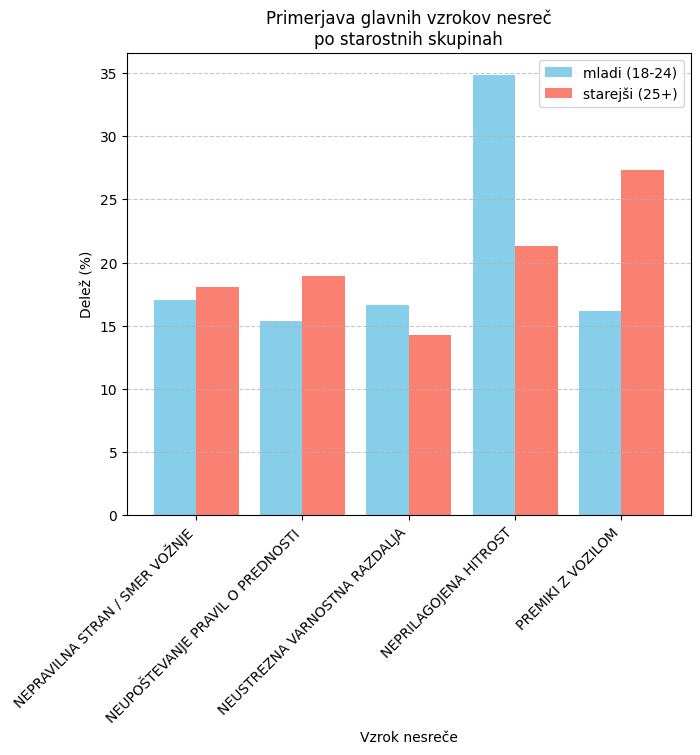

In [6]:
def compare_causes_and_alcohol(data):
    povzrocitelji = data[data['Povzrocitelj'] == 'POVZROČITELJ'].copy()
    povzrocitelji['StarostnaSkupina'] = ['mladi (18-24)' if 18 <= x <= 24 else 'starejši (25+)' for x in povzrocitelji['Starost']]
    
    plt.figure(figsize=(16, 6))
    
    plt.subplot(1, 2, 1)
    
    top_vzroki_mladi = povzrocitelji[povzrocitelji['StarostnaSkupina'] == 'mladi (18-24)']['VzrokNesrece'].value_counts().head(5)
    top_vzroki_starejsi = povzrocitelji[povzrocitelji['StarostnaSkupina'] == 'starejši (25+)']['VzrokNesrece'].value_counts().head(5)
    
    vsi_vzroki = set(top_vzroki_mladi.index).union(set(top_vzroki_starejsi.index))
    
    vzroki_df = pd.DataFrame({
        'mladi (18-24)': povzrocitelji[povzrocitelji['StarostnaSkupina'] == 'mladi (18-24)']['VzrokNesrece'].value_counts(),
        'starejši (25+)': povzrocitelji[povzrocitelji['StarostnaSkupina'] == 'starejši (25+)']['VzrokNesrece'].value_counts()
    }).fillna(0)
    
    vzroki_df = vzroki_df.loc[list(vsi_vzroki)]
    
    vzroki_df = vzroki_df.div(vzroki_df.sum()) * 100
    
    vzroki_df.plot(kind='bar', ax=plt.gca(), width=0.8, color=['skyblue', 'salmon'])
    plt.title('Primerjava glavnih vzrokov nesreč\npo starostnih skupinah')
    plt.ylabel('Delež (%)')
    plt.xlabel('Vzrok nesreče')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
   

compare_causes_and_alcohol(accident_data)

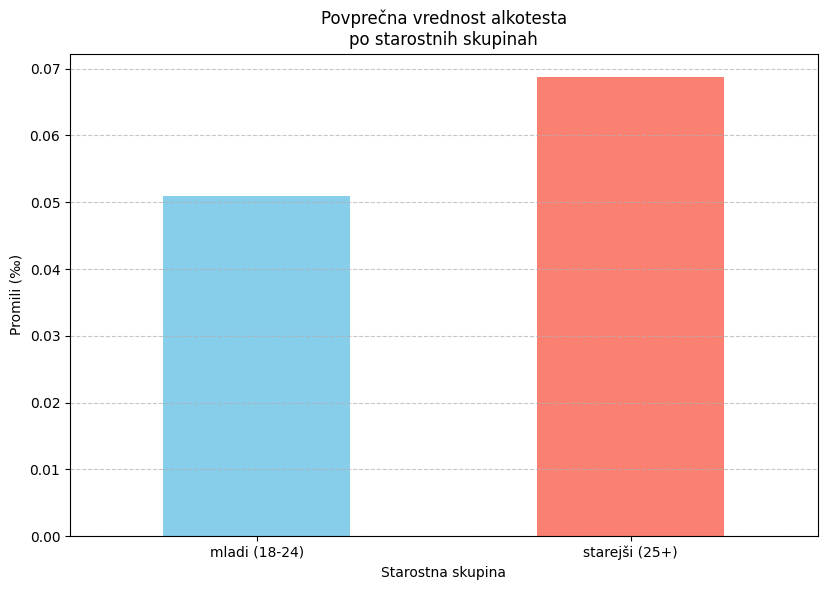

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

def compare_causes_and_alcohol(data):
    povzrocitelji = data[data['Povzrocitelj'] == 'POVZROČITELJ'].copy()
    
    povzrocitelji['VrednostAlkotesta'] = (
        povzrocitelji['VrednostAlkotesta']
        .astype(str)
        .str.replace(',', '.', regex=False)
        .str.replace('"', '', regex=False)
        .str.strip()
        .replace('', '0')
        .astype(float)
    )
    
    povzrocitelji['StarostnaSkupina'] = povzrocitelji['Starost'].apply(
        lambda x: 'mladi (18-24)' if 18 <= x <= 24 else 'starejši (25+)'
    )

    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 2)
    alkotest_po_skupinah = povzrocitelji.groupby('StarostnaSkupina')['VrednostAlkotesta'].mean()
    alkotest_po_skupinah.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title('Povprečna vrednost alkotesta\npo starostnih skupinah')
    plt.ylabel('Promili (‰)')
    plt.xlabel('Starostna skupina')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

compare_causes_and_alcohol(accident_data)

### 4. Vpliv alkohola na prometne nesreče

In [8]:
import pandas as pd

df = accident_data

povzrocitelji = df[df['Povzrocitelj'] == 'POVZROČITELJ'].copy()

def parse_alko(val):
    try:
        return float(str(val).replace(",", ".").replace(" ", ""))
    except:
        return 0.0

povzrocitelji['VrednostAlkotesta_float'] = povzrocitelji['VrednostAlkotesta'].apply(parse_alko)
alko_povzrocitelji = povzrocitelji[povzrocitelji['VrednostAlkotesta_float'] > 0]
nad_mejo = povzrocitelji[povzrocitelji['VrednostAlkotesta_float'] > 0.5]
delež_nad_mejo = len(nad_mejo) / len(povzrocitelji) * 100 if len(povzrocitelji) > 0 else 0

print(f"Delež povzročiteljev pod vplivom alkohola: {len(alko_povzrocitelji)} / {len(povzrocitelji)} ({len(alko_povzrocitelji)/len(povzrocitelji)*100:.2f} %)")
print(f"Število povzročiteljev nad dovoljeno mejo (0.5 g/kg): {len(nad_mejo)} ({delež_nad_mejo:.2f} % vseh povzročiteljev)")

Delež povzročiteljev pod vplivom alkohola: 26688 / 243915 (10.94 %)
Število povzročiteljev nad dovoljeno mejo (0.5 g/kg): 16235 (6.66 % vseh povzročiteljev)


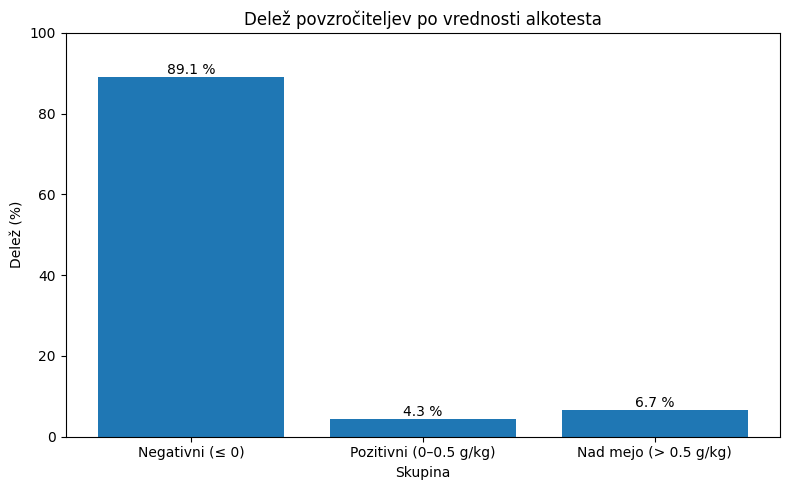

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

df = accident_data
povzrocitelji = df[df['Povzrocitelj'] == 'POVZROČITELJ'].copy()

def parse_alko(val):
    try:
        return float(str(val).replace(",", ".").replace(" ", ""))
    except:
        return 0.0

povzrocitelji['VrednostAlkotesta_float'] = povzrocitelji['VrednostAlkotesta'].apply(parse_alko)

negativni = (povzrocitelji['VrednostAlkotesta_float'] == 0).sum()
pozitivni_pod_mejo = ((povzrocitelji['VrednostAlkotesta_float'] > 0) & (povzrocitelji['VrednostAlkotesta_float'] <= 0.5)).sum()
nad_mejo = (povzrocitelji['VrednostAlkotesta_float'] > 0.5).sum()

labels = ['Negativni (≤ 0)', 'Pozitivni (0–0.5 g/kg)', 'Nad mejo (> 0.5 g/kg)']
values = [negativni, pozitivni_pod_mejo, nad_mejo]

total = sum(values)
percentages = [v / total * 100 for v in values]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, percentages)
plt.title('Delež povzročiteljev po vrednosti alkotesta')
plt.ylabel('Delež (%)')
plt.xlabel('Skupina')
plt.ylim(0, 100)
plt.bar_label(bars, fmt='%.1f %%')
plt.tight_layout()
plt.show()

In [10]:
import pandas as pd

df = accident_data

df['VrednostAlkotesta_float'] = df['VrednostAlkotesta'].apply(parse_alko)
nesrece_pijanec = df[(df['Povzrocitelj'] == 'POVZROČITELJ') & (df['VrednostAlkotesta_float'] > 0)]['ZaporednaStevilkaPN'].unique()

hudo_poskodovani_v_pijani_nesreci = df[(df['ZaporednaStevilkaPN'].isin(nesrece_pijanec)) & 
                                       (df['PoskodbaUdelezenca'] == 'HUDA TELESNA POŠKODBA')]

print(f"Število udeležencev s hudo telesno poškodbo, ki so jih povzročili pijani vozniki: {len(hudo_poskodovani_v_pijani_nesreci)}")

vsi_hudo_poskodovani = df[df['PoskodbaUdelezenca'] == 'HUDA TELESNA POŠKODBA']
delež = len(hudo_poskodovani_v_pijani_nesreci) / len(vsi_hudo_poskodovani) * 100

print(f"To je {delež:.2f} % vseh udeležencev s hudo poškodbo.")

Število udeležencev s hudo telesno poškodbo, ki so jih povzročili pijani vozniki: 9528
To je 74.68 % vseh udeležencev s hudo poškodbo.


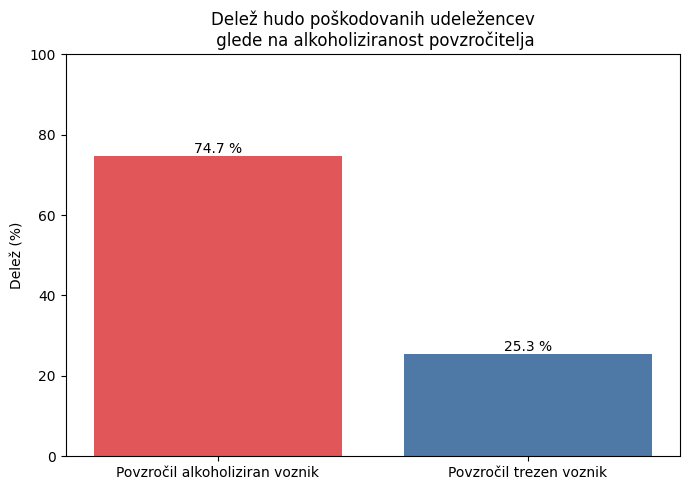

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

df = accident_data

df['VrednostAlkotesta_float'] = df['VrednostAlkotesta'].apply(parse_alko)

nesrece_pijanec = df[(df['Povzrocitelj'] == 'POVZROČITELJ') & (df['VrednostAlkotesta_float'] > 0)]['ZaporednaStevilkaPN'].unique()
hudo_v_pijani = df[(df['ZaporednaStevilkaPN'].isin(nesrece_pijanec)) & (df['PoskodbaUdelezenca'] == 'HUDA TELESNA POŠKODBA')]

vsi_hudo = df[df['PoskodbaUdelezenca'] == 'HUDA TELESNA POŠKODBA']
hudo_v_trezni = len(vsi_hudo) - len(hudo_v_pijani)

labels = ['Povzročil alkoholiziran voznik', 'Povzročil trezen voznik']
values = [len(hudo_v_pijani), hudo_v_trezni]
percentages = [v / len(vsi_hudo) * 100 for v in values]

plt.figure(figsize=(7,5))
bars = plt.bar(labels, percentages, color=['#e15759', '#4e79a7'])
plt.ylabel('Delež (%)')
plt.title('Delež hudo poškodovanih udeležencev\n glede na alkoholiziranost povzročitelja')
plt.ylim(0, 100)
plt.bar_label(bars, fmt='%.1f %%')
plt.tight_layout()
plt.show()

### 5. Uporaba varnostnega pasu

UporabaVarnostnegaPasu      DA     NE
PoskodbaUdelezenca                   
BREZ POŠKODBE           314186  21670
LAŽJA TELESNA POŠKODBA   87659  14770
HUDA TELESNA POŠKODBA     7445   3643
BREZ POŠKODBE-UZ          3375    894
SMRT                       869    642
ODSTOP OD OGLEDA PN          2      0

Smrtnost med udeleženci Z varnostnim pasom: 0.210%
Smrtnost med udeleženci BREZ varnostnega pasu: 1.543%


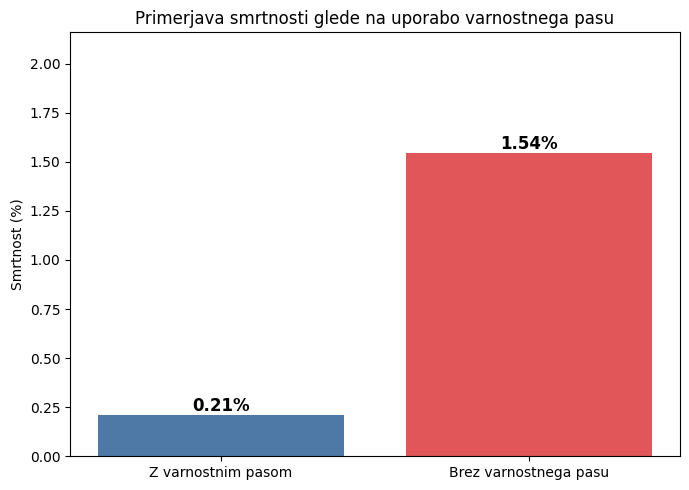

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

df = accident_data

df_pas = df[df['UporabaVarnostnegaPasu'].isin(['DA', 'NE'])]

# Pivot tabela: vrste poškodb × pas DA/NE
pivot = pd.pivot_table(
    df_pas,
    index='PoskodbaUdelezenca',
    columns='UporabaVarnostnegaPasu',
    aggfunc='size',
    fill_value=0
)

pivot = pivot.reindex(pivot.sum(axis=1).sort_values(ascending=False).index)
print(pivot)

umrli_z_pasu = pivot.loc['SMRT', 'DA'] if 'SMRT' in pivot.index else 0
umrli_brez_pasu = pivot.loc['SMRT', 'NE'] if 'SMRT' in pivot.index else 0

skupaj_z_pasu = pivot['DA'].sum()
skupaj_brez_pasu = pivot['NE'].sum()

smrtnost_z_pasu = umrli_z_pasu / skupaj_z_pasu * 100 if skupaj_z_pasu > 0 else 0
smrtnost_brez_pasu = umrli_brez_pasu / skupaj_brez_pasu * 100 if skupaj_brez_pasu > 0 else 0

print(f"\nSmrtnost med udeleženci Z varnostnim pasom: {smrtnost_z_pasu:.3f}%")
print(f"Smrtnost med udeleženci BREZ varnostnega pasu: {smrtnost_brez_pasu:.3f}%")

labels = ['Z varnostnim pasom', 'Brez varnostnega pasu']
values = [smrtnost_z_pasu, smrtnost_brez_pasu]

plt.figure(figsize=(7,5))
bars = plt.bar(labels, values, color=['#4e79a7', '#e15759'])
plt.ylabel('Smrtnost (%)')
plt.title('Primerjava smrtnosti glede na uporabo varnostnega pasu')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{bar.get_height():.2f}%', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylim(0, max(values)*1.4)
plt.tight_layout()
plt.show()

                        Z varnostnim pasom  Brez varnostnega pasu
SMRT                                  0.21                   1.58
HUDA TELESNA POŠKODBA                 1.82                   8.95
LAŽJA TELESNA POŠKODBA               21.37                  36.27
BREZ POŠKODBE                        76.60                  53.21


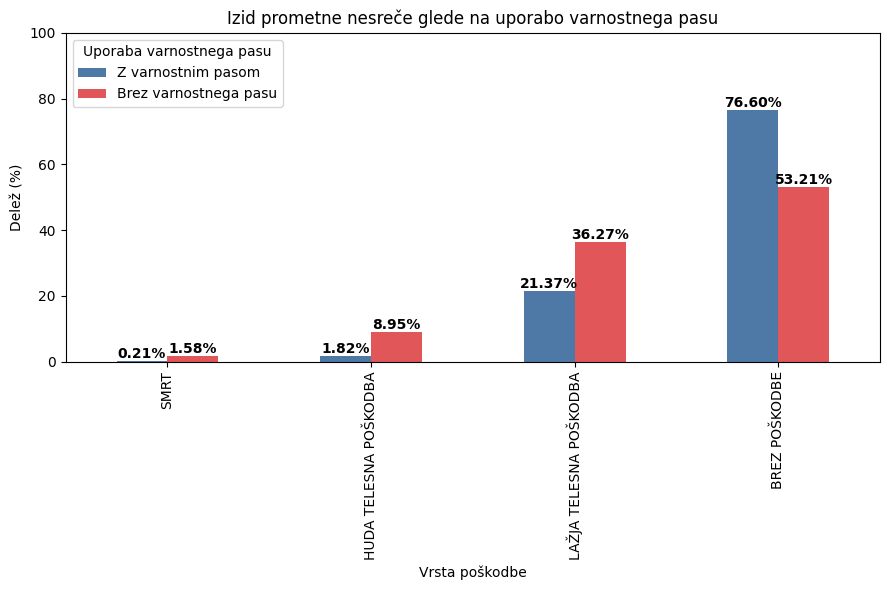

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

df = accident_data

df_pas = df[df['UporabaVarnostnegaPasu'].isin(['DA', 'NE'])]

pivot = pd.pivot_table(
    df_pas,
    index='PoskodbaUdelezenca',
    columns='UporabaVarnostnegaPasu',
    aggfunc='size',
    fill_value=0
)

kategorije = ['SMRT', 'HUDA TELESNA POŠKODBA', 'LAŽJA TELESNA POŠKODBA', 'BREZ POŠKODBE']
pivot = pivot.reindex(kategorije)

skupaj_z_pasu = pivot['DA'].sum()
skupaj_brez_pasu = pivot['NE'].sum()

delezi = pd.DataFrame({
    'Z varnostnim pasom': (pivot['DA'] / skupaj_z_pasu * 100).round(2),
    'Brez varnostnega pasu': (pivot['NE'] / skupaj_brez_pasu * 100).round(2)
}, index=kategorije)

print(delezi)

ax = delezi.plot(kind='bar', figsize=(9,6), color=['#4e79a7', '#e15759'])
plt.ylabel('Delež (%)')
plt.xlabel('Vrsta poškodbe')
plt.title('Izid prometne nesreče glede na uporabo varnostnega pasu')
plt.legend(title='Uporaba varnostnega pasu')
plt.ylim(0, 100)

for p in ax.patches:
    if not pd.isna(p.get_height()):
        ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width()/2., p.get_height()),
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### 6. Vpliv spola na prometne nesreče

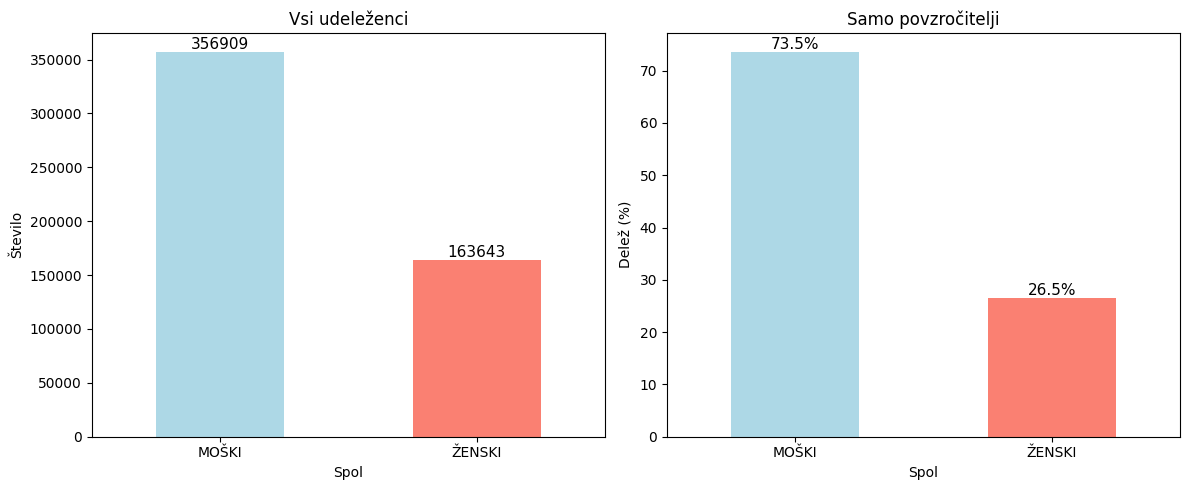

In [14]:
import matplotlib.pyplot as plt

def accidents_by_gender_side_by_side(data):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    df1 = data.copy()
    spoli1 = df1['Spol'].dropna()
    spoli1 = spoli1[~spoli1.isin(['NEZNAN', 'NI PODATKA'])]
    counts1 = spoli1.value_counts()
    ax1 = axes[0]
    counts1.plot(kind='bar', color=['lightblue', 'salmon'], ax=ax1)
    ax1.set_title('Vsi udeleženci')
    ax1.set_xlabel('Spol')
    ax1.set_ylabel('Število')
    ax1.set_xticklabels(counts1.index, rotation=0)
    for p in ax1.patches:
        ax1.annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', fontsize=11)

    df2 = data[data['Povzrocitelj'] == 'POVZROČITELJ'].copy()
    spoli2 = df2['Spol'].dropna()
    spoli2 = spoli2[~spoli2.isin(['NEZNAN', 'NI PODATKA'])]
    counts2 = spoli2.value_counts()
    perc2 = counts2 / counts2.sum() * 100
    ax2 = axes[1]
    perc2.plot(kind='bar', color=['lightblue', 'salmon'], ax=ax2)
    ax2.set_title('Samo povzročitelji')
    ax2.set_xlabel('Spol')
    ax2.set_ylabel('Delež (%)')
    ax2.set_xticklabels(perc2.index, rotation=0)
    for p in ax2.patches:
        ax2.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='bottom', fontsize=11)

    plt.tight_layout()
    plt.show()

accidents_by_gender_side_by_side(accident_data)

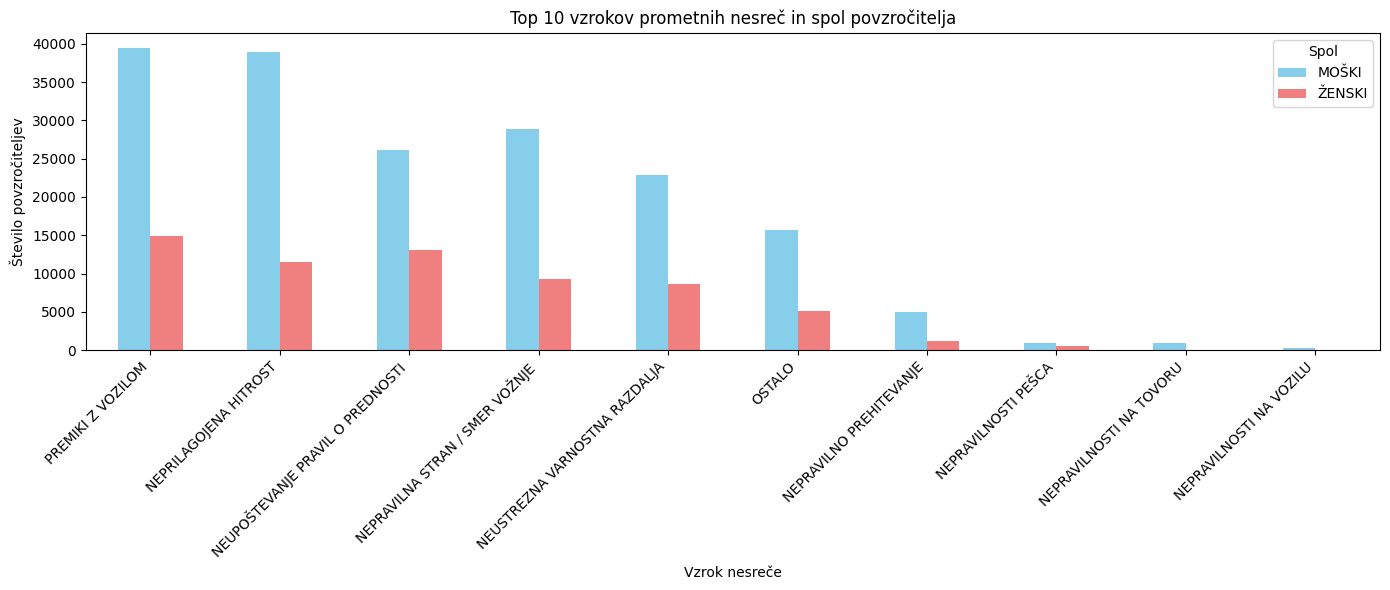

In [15]:
import matplotlib.pyplot as plt

def gender_by_cause(data, top_n=10):
    povzrocitelji = data[data['Povzrocitelj'] == 'POVZROČITELJ'].copy()
    povzrocitelji = povzrocitelji[povzrocitelji['Spol'].isin(['MOŠKI', 'ŽENSKI'])]

    top_vzroki = povzrocitelji['VzrokNesrece'].value_counts().head(top_n).index

    tabela = povzrocitelji[povzrocitelji['VzrokNesrece'].isin(top_vzroki)]
    pivot = tabela.pivot_table(index='VzrokNesrece', columns='Spol', values='ZaporednaStevilkaPN', aggfunc='count', fill_value=0)
    pivot = pivot.loc[top_vzroki]

    pivot.plot(kind='bar', figsize=(14, 6), color=['skyblue', 'lightcoral'])
    plt.title(f'Top {top_n} vzrokov prometnih nesreč in spol povzročitelja')
    plt.xlabel('Vzrok nesreče')
    plt.ylabel('Število povzročiteljev')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Spol')
    plt.tight_layout()
    plt.show()

gender_by_cause(accident_data, top_n=10)

### 7. Vpliv letnega časa na nesreče

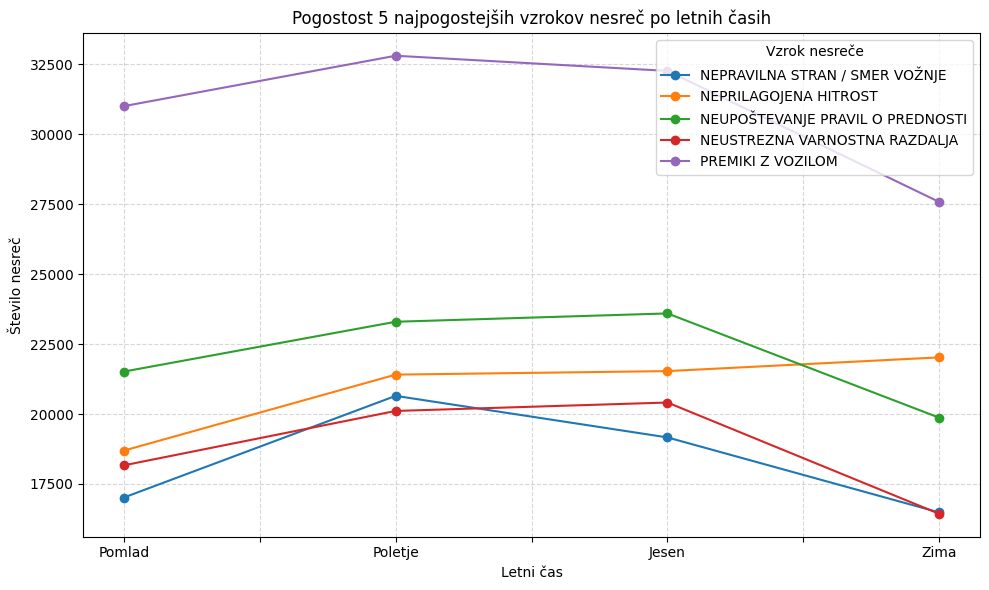

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

def trend_by_season_and_cause(data, top_n=5):
    df = data.copy()
    df['Mesec'] = pd.to_datetime(df['DatumPN'], errors='coerce').dt.month
    sezona_map = {
        12: 'Zima', 1: 'Zima', 2: 'Zima',
        3: 'Pomlad', 4: 'Pomlad', 5: 'Pomlad',
        6: 'Poletje', 7: 'Poletje', 8: 'Poletje',
        9: 'Jesen', 10: 'Jesen', 11: 'Jesen'
    }
    df['LetniCas'] = df['Mesec'].map(sezona_map)

    top_vzroki = df['VzrokNesrece'].value_counts().head(top_n).index
    df_top = df[df['VzrokNesrece'].isin(top_vzroki)]

    tabela = df_top.groupby(['LetniCas', 'VzrokNesrece']).size().unstack().fillna(0)
    season_order = ['Pomlad', 'Poletje', 'Jesen', 'Zima']
    tabela = tabela.reindex(season_order)

    plt.figure(figsize=(10, 6))
    tabela.plot(ax=plt.gca(), marker='o')
    plt.title(f'Pogostost {top_n} najpogostejših vzrokov nesreč po letnih časih')
    plt.xlabel('Letni čas')
    plt.ylabel('Število nesreč')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(title='Vzrok nesreče')
    plt.tight_layout()
    plt.show()

trend_by_season_and_cause(accident_data, top_n=5)